In [1]:
import os
import pickle

import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
DATA_LOAD = False

TRAIN_PREDICTIONS_FILENAME = "../runs/densenet_v3_256/densenet_v3_256_train_predictions.pkl"
TRAIN_GROUD_TRUE = "../data/train/landmarks.csv"
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [3]:
noisy_path = os.path.join('../data/train', 'noisy.txt')
with open(noisy_path, "rb") as fp:
    noisy_file = pickle.load(fp)

In [4]:
df = pd.read_csv(TRAIN_GROUD_TRUE, sep='\t')
#df = df[~df['file_name'].isin(noisy_file)]
print(f"Train Dataset: {len(df)}")

Train Dataset: 64000


In [5]:
with open(TRAIN_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

Images: 64000
Landmarks shape: (64000, 971, 2)


In [6]:
def make_landmarks(row):
    landmark = row[1:]
    land_mark_len = landmark.shape[0]
    landmark = landmark.reshape(int(land_mark_len/2), 2)
    return landmark

In [7]:
def draw_landmarks(image, landmarks, ground_true):
    for point in ground_true:
        x, y = point.astype(int)
        cv2.circle(image, (x, y), 1, (0, 128, 0), 1, -1)
    for point in landmarks:
        x, y = point.astype(int)
        cv2.circle(image, (x, y), 1, (128, 0, 0), 1, -1)
    return image

In [8]:
if DATA_LOAD:
    df = pd.read_csv('../data/train/error_ground_true.csv', index_col=0)
    df['MSE'] = df['MSE'].apply(abs)
else:
    error = []
    for i in tqdm(range(len(image_names))):
        image = cv2.imread('../' + image_names[i])
        image_name = image_names[i].split('/')[-1]
        train_land = make_landmarks(df[df['file_name'] == image_name].iloc[0].values)
        predict_land = landmarks[i]
        error.append(np.mean(train_land - predict_land))
    df['MSE'] = error
    df['MSE'] = df['MSE'].apply(abs)
    df.to_csv('../data/train/error_ground_true.csv')

100%|██████████| 64000/64000 [09:06<00:00, 117.19it/s]


In [9]:
df.reset_index(inplace=True)

In [10]:
len_ind = min(NUM_IMAGES_TO_SHOW, len(image_names))
ind = df.sort_values('MSE', ascending=False).index[:len_ind]

In [11]:
def make_landmarks(row):
    landmark = row[2:-1]
    land_mark_len = landmark.shape[0]
    landmark = landmark.reshape(int(land_mark_len/2), 2)
    return landmark

In [12]:
ROW_NUM, COL_NUM = 5, 10

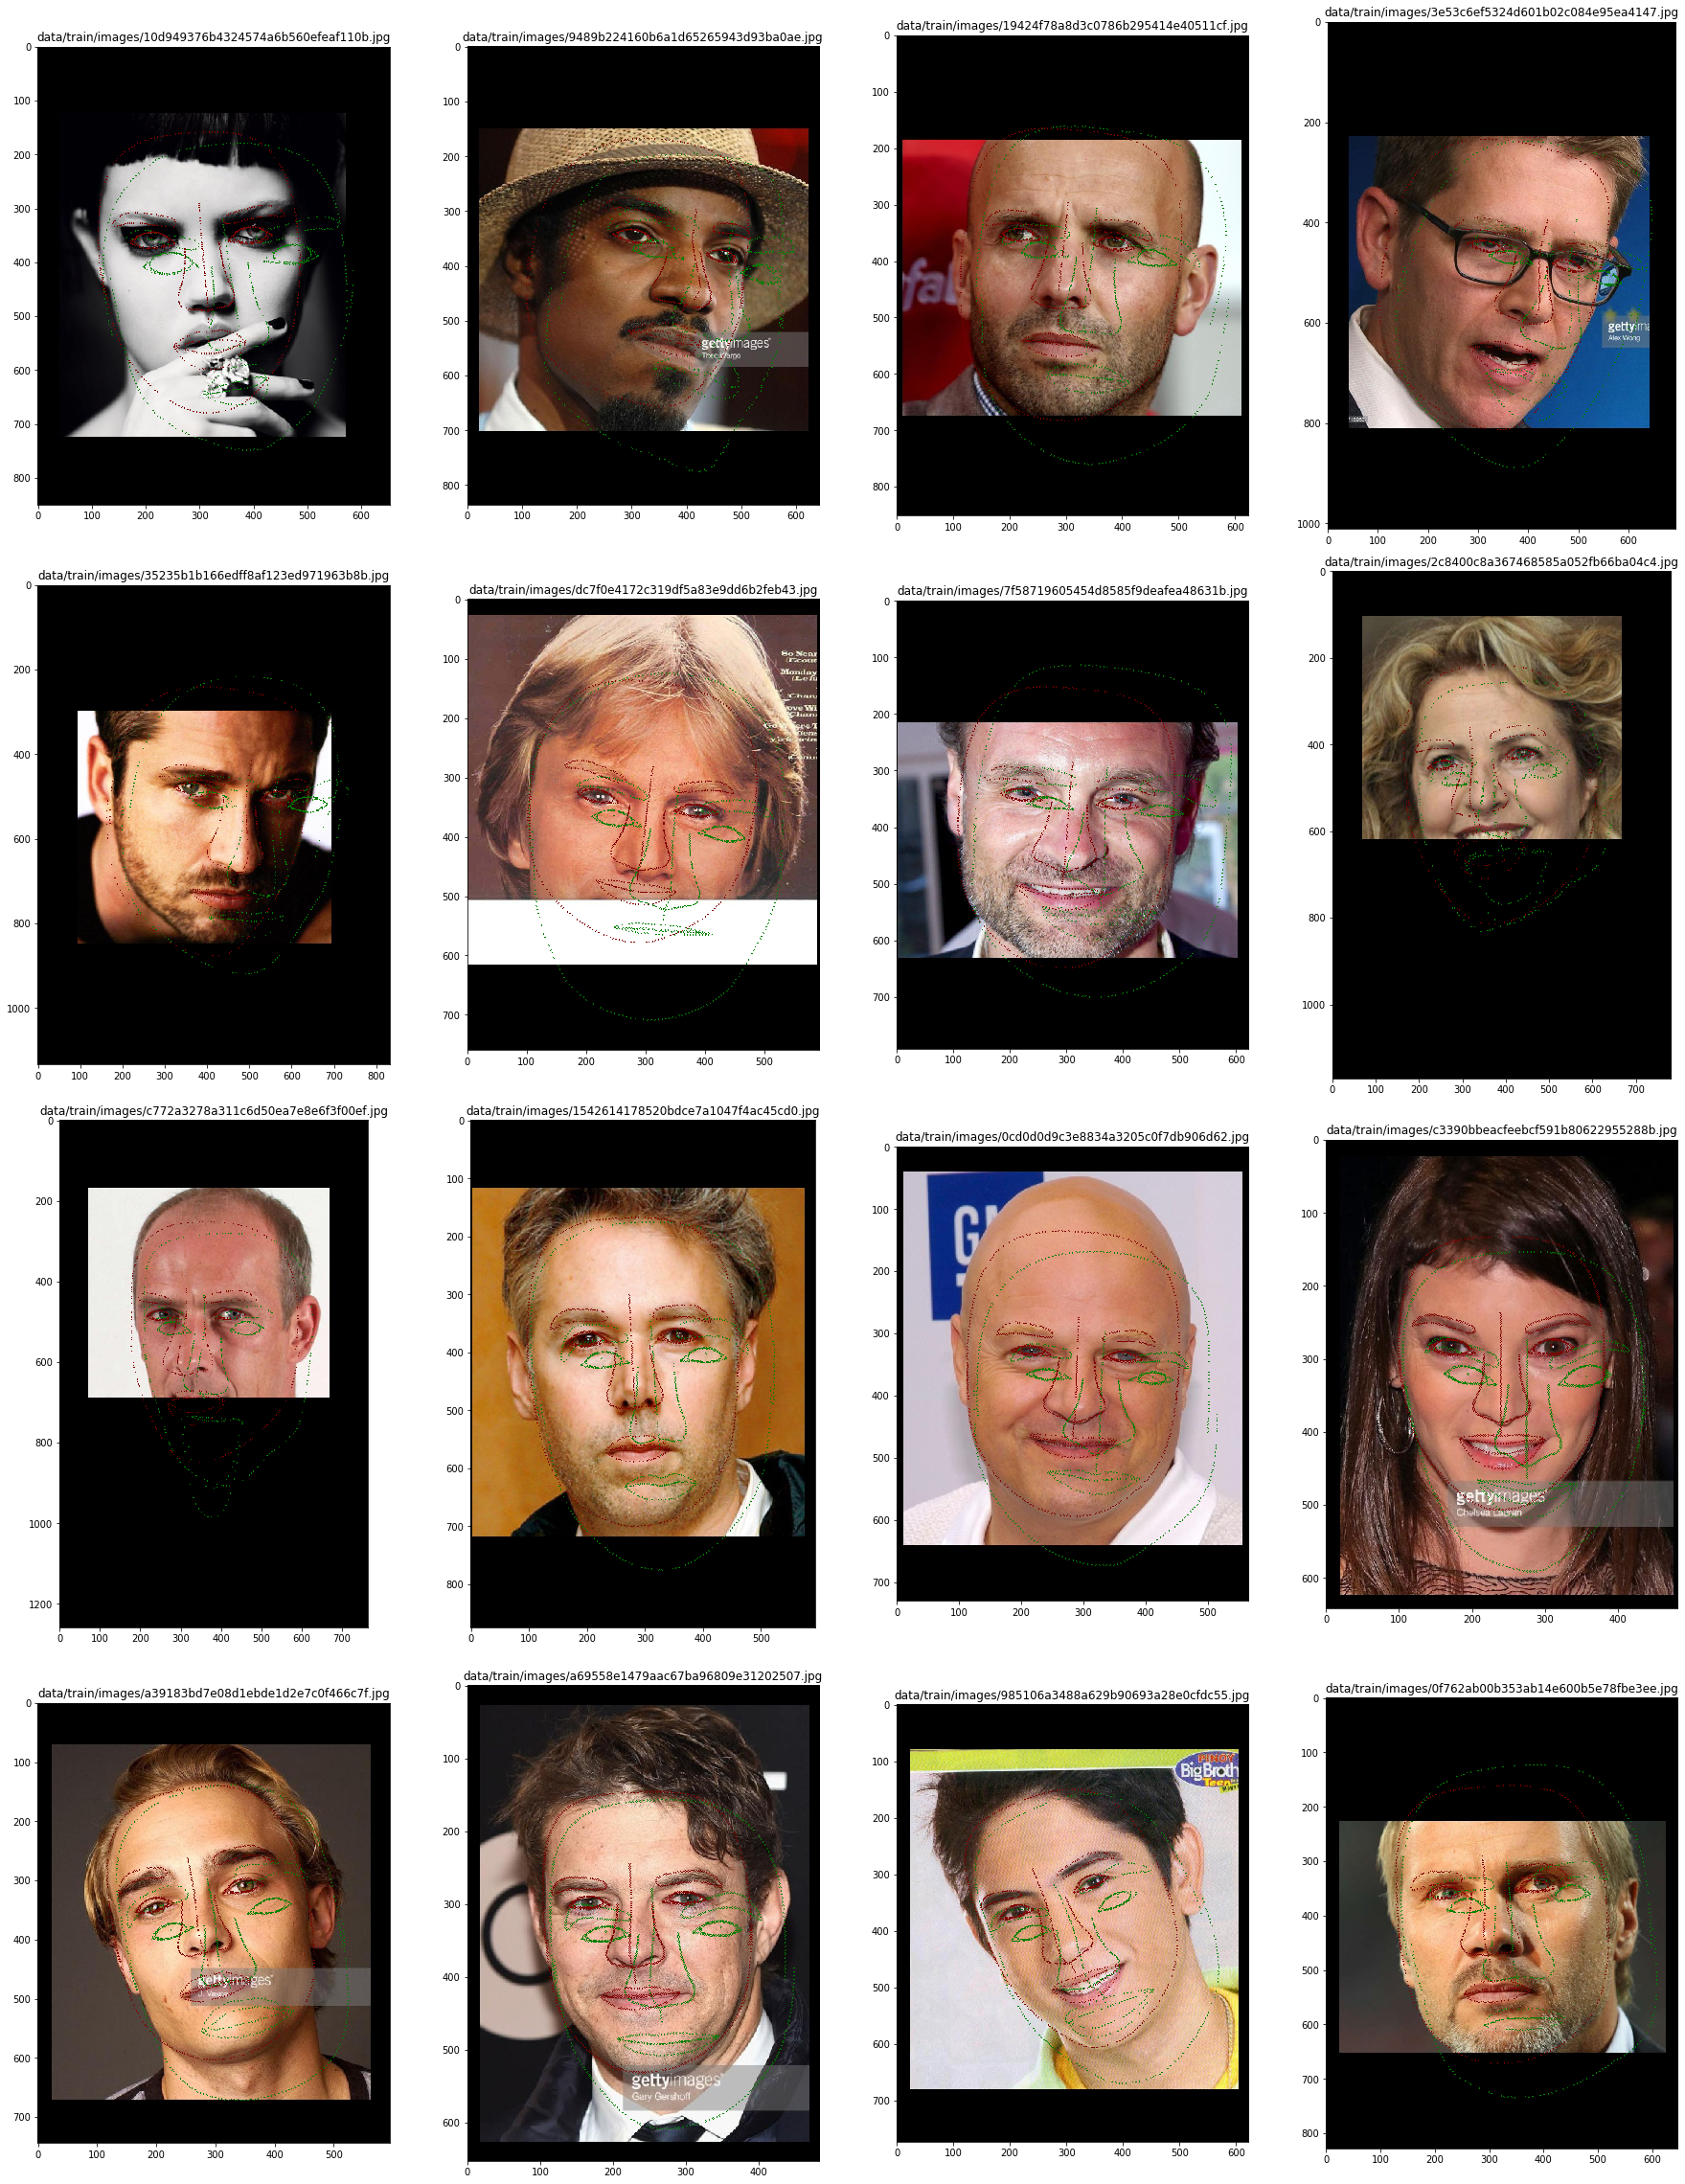

In [13]:
plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(ind, 1):
    image = cv2.imread('../' + image_names[idx])
    image_name = image_names[idx].split('/')[-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx], make_landmarks(df[df['file_name'] == image_name].iloc[0].values))
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)
    plt.title(image_names[idx])
    
plt.tight_layout()
plt.show()

In [14]:
shift_image = df.sort_values('MSE', ascending=False).iloc[:len_ind * 34]

In [15]:
ignore = [36527, 62273, 21465, 53123, 60400, 26623, 1534, 8192, 7036, 1123, 27847, 9065, 11535, 51643, 35384, 44253]

In [16]:
shift_image[~shift_image['index'].isin(ignore)]

index                             file_name  Point_0_X  Point_0_Y  \
36363  36363  10d949376b4324574a6b560efeaf110b.jpg        373        747   
4012    4012  9489b224160b6a1d65265943d93ba0ae.jpg        392        769   
47548  47548  19424f78a8d3c0786b295414e40511cf.jpg        327        760   
27537  27537  3e53c6ef5324d601b02c084e95ea4147.jpg        364        889   
21515  21515  35235b1b166edff8af123ed971963b8b.jpg        492        920   
...      ...                                   ...        ...        ...   
22798  22798  bca5e0944bab9a3767a079ac2062c8c7.jpg        267        651   
60968  60968  7ba8a90324d77cdf4935a0876d8b9afd.jpg        271        528   
22865  22865  656f94446c5d9ca4be7408c6fa452fd0.jpg        312        494   
12554  12554  456aa02580fc919d675a38613ddb7ced.jpg        263        541   
45241  45241  a611e41f4b31533599ddb2104dd002b4.jpg        245        495   

       Point_1_X  Point_1_Y  Point_2_X  Point_2_Y  Point_3_X  Point_3_Y  ...  \
36363        366        746        359        745        351        744  ...   
4012         382        765        373        761        367        757  ...   
47548        322        759        316        758        311        757  ...   
27537        357        888        349        886        342        884  ...   
21515        484        920        477        919        469        918  ...   
...          ...        ...        ...        ...        ...        ...  ...   
22798        261        651        254        651        248        650  ...   
60968        266        529        262        530        257        530  ...   
22865        308        494        304        493        300        493  ...   
12554        258        542        253        543        249        543  ...   
45241        239        494        234        492        229        491  ...   

       Point_966_Y  Point_967_X  Point_967_Y  Point_968_X  Point_968_Y  \
36363          645          310          645          310          644   
4012           587          341          587          343          587   
47548          603          267          603          267          603   
27537          708          318          704          317          702   
21515          788          410          788          406          787   
...            ...          ...          ...          ...          ...   
22798          553          212          552          211          552   
60968          433          210          434          209          434   
22865          410          251          411          252          411   
12554          428          194          427          193          426   
45241          390          200          391          200          390   

       Point_969_X  Point_969_Y  Point_970_X  Point_970_Y        MSE  
36363          246          395          473          381  50.742949  
4012           344          364          533          410  49.939201  
47548          248          379          451          391  44.824712  
27537          359          463          557          506  44.481744  
21515          400          501          635          512  44.227622  
...            ...          ...          ...          ...        ...  
22798          190          376          347          363   7.935334  
60968          175          294          288          286   7.932618  
22865          228          286          356          280   7.930539  
12554          163          294          290          262   7.922232  
45241          204          252          319          297   7.901964  

[529 rows x 1945 columns]

In [17]:
shift_file = list(shift_image['file_name'].values)

In [18]:
bad_list = [57263, 63816, 21699, 31916, 14079, 25937, 62561, 63053, 41538]

In [19]:
bad_list = df[df['index'].isin(bad_list)]['file_name'].to_list()

In [20]:
shift_file.extend(bad_list)

In [21]:
with open("../data/train/shift_file.txt", "wb") as fp:
    pickle.dump(shift_file, fp)